In [2]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy import interpolate
from astropy.io import fits

In [44]:
def transfer_function(spin, inc, defpar, Mdl = 0.0, selection = None, selet_tor = 0.01, custom_name = None, clean = True):
    if custom_name:
        filename = custom_name
    else:
        filename = r'C:\Users\WalkerXin\Documents\Scripts\raytransfer\photons\photons4trf_a{:.5e}.i{:.2e}.Mdl_{:.2e}.dp_{:.2e}.dat'.format(spin, inc, Mdl, defpar)
        # Add num pad to exopnent
        filename = filename.replace('e+0', 'e+00')
        filename = filename.replace('e-0', 'e-00')
    
    # Check if file exists
    try:
        with open(filename):
            pass
    except IOError:
        print('File does not exist')
        return None
    
    re, g, xobs, yobs, cosem, gminus, xobsminus, yobsminus, gplus, xobsplus, yobsplus = np.loadtxt(filename, unpack=True)
    
    branch_1 = pd.DataFrame(columns=['transfer', 'gstar', 'r', 'cosem', 'transfer_ori'])
    branch_2 = pd.DataFrame(columns=['transfer', 'gstar', 'r', 'cosem', 'transfer_ori'])

    maxlines = len(re)-1

    for i in range(1, maxlines//84):
        gmax = g[(i+1)*84-1]
        gmin = g[i*84]

        trff1 = []
        trff2 = []
        trff_ori1 = []
        trff_ori2 = []
        cosem1 = []
        cosem2 = []
        g_star_1 = []
        g_star_2 = []
        r_1 = []
        r_2 = []

        # Branch 1
        for j in range(1, 41):

            # Set positions of current value and values at higher and lower radius
            poscur = i*84+j
            posrplus = poscur-84
            posrminus = poscur+84

            # Calculate transfer function

            dxdr = (xobs[posrplus]-xobs[posrminus]) / \
                (re[posrplus]-re[posrminus])
            dydr = (yobs[posrplus]-yobs[posrminus]) / \
                (re[posrplus]-re[posrminus])
            dxdg = (xobsplus[poscur]-xobsminus[poscur]
                    )/(gplus[poscur]-gminus[poscur])
            dydg = (yobsplus[poscur]-yobsminus[poscur]
                    )/(gplus[poscur]-gminus[poscur])
            jac = -(dxdg*dydr-dxdr*dydg)

            recur = re[poscur]
            gcur = g[poscur]

            if (gmax-gcur < 0):
                gcur = gmax
                
            trans_ori = gcur*np.sqrt((gmax-gcur)*(gcur-gmin))*jac/(np.pi*recur) # original transfer function formula
                
            g_star = (gcur - gmin) / (gmax - gmin)
            trans = gcur*np.sqrt(g_star*(1 - g_star))*jac/(np.pi*recur) # formula in Abdikamalov 2019
            
            if g_star < 0 or g_star > 1:
                print(trans)
            
            try:
                assert trans_ori == trans
            except AssertionError:
                # print('Not equal')
                # print('trans_ori = {}, trans = {}'.format(trans_ori, trans))
                pass
                
            trff_ori1.append(trans_ori)
            trff1.append(trans)
            cosem1.append(cosem[poscur])
            g_star_1.append(g_star)
            r_1.append(re[poscur])

        # Branch 2
        for j in range(43, 83):

            # Set positions of current value and values at higher and lower radius
            poscur = i*84+j
            posrplus = poscur-84
            posrminus = poscur+84

            # Calculate transfer function

            dxdr = (xobs[posrplus]-xobs[posrminus]) / \
                (re[posrplus]-re[posrminus])
            dydr = (yobs[posrplus]-yobs[posrminus]) / \
                (re[posrplus]-re[posrminus])
            dxdg = (xobsplus[poscur]-xobsminus[poscur]
                    )/(gplus[poscur]-gminus[poscur])
            dydg = (yobsplus[poscur]-yobsminus[poscur]
                    )/(gplus[poscur]-gminus[poscur])
            jac = (dxdg*dydr-dxdr*dydg)

            recur = re[poscur]
            gcur = g[poscur]

            # In case there are redshift values larger than the maximum
            if (gmax-gcur < 0):
                gcur = gmax
                
            g_star = (gcur - gmin) / (gmax - gmin)
            
            try:
                assert g_star >= 0 and g_star <= 1
            except AssertionError:
                print('g_star =', g_star, 'gcur =', gcur, 'gmin =', gmin, 'gmax =', gmax)

            trans_ori = gcur*np.sqrt((gmax-gcur)*(gcur-gmin))*jac/(np.pi*recur)
            trans = gcur*np.sqrt(g_star*(1 - g_star))*jac/(np.pi*recur)
            if g_star < 0 or g_star > 1:
                print(trans)
                
            trff_ori2.append(trans_ori)
            trff2.append(trans)
            cosem2.append(cosem[poscur])
            g_star_2.append(g_star)
            r_2.append(re[poscur])
            
        # Append to branches
        if branch_1.empty:
            branch_1 = pd.DataFrame({'transfer': trff1, 'gstar': g_star_1, 'r': r_1, 'cosem': cosem1, 'transfer_ori': trff_ori1})
            branch_2 = pd.DataFrame({'transfer': trff2, 'gstar': g_star_2, 'r': r_2, 'cosem': cosem2, 'transfer_ori': trff_ori2})
        else:
            branch_1 = pd.concat([branch_1, pd.DataFrame({'transfer': trff1, 'gstar': g_star_1, 'r': r_1, 'cosem': cosem1, 'transfer_ori': trff_ori1})], ignore_index=True)
            branch_2 = pd.concat([branch_2, pd.DataFrame({'transfer': trff2, 'gstar': g_star_2, 'r': r_2, 'cosem': cosem2, 'transfer_ori': trff_ori2})], ignore_index=True)
            
    if selection:
        branch_1 = branch_1[(branch_1['r'] >= selection - selet_tor) & (branch_1['r'] <= selection + selet_tor)]
        branch_2 = branch_2[(branch_2['r'] >= selection - selet_tor) & (branch_2['r'] <= selection + selet_tor)]
        
    # Remove extreme values
    if clean:
        branch_1 = branch_1[(branch_1['transfer_ori'] > 0) & (branch_1['transfer_ori'] < clean)]
        branch_2 = branch_2[(branch_2['transfer_ori'] > 0) & (branch_2['transfer_ori'] < clean)]
    
    return branch_1, branch_2

In [4]:
gtr_files = r'C:\Users\WalkerXin\Documents\Scripts\raytransfer\photons_gtr'
grp_files = r'C:\Users\WalkerXin\Documents\Scripts\raytransfer\photons_grp'
photon_files = r'C:\Users\WalkerXin\Documents\Scripts\raytransfer\photons'

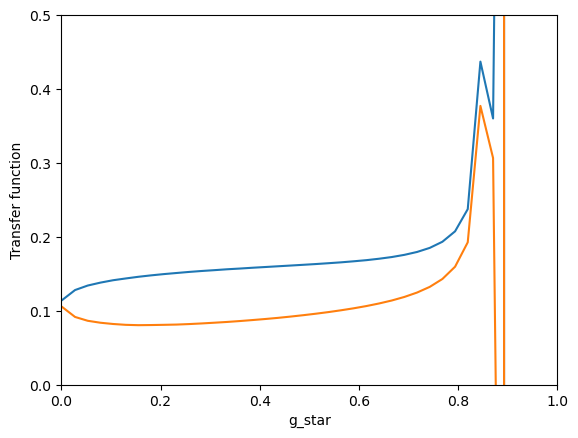

In [55]:
spin = 0.998
inc = np.cos(np.pi/4)
defpar = 0
Mdl = 0.0

r = 1.52

filename = r'C:\Users\WalkerXin\Documents\Scripts\raytransfer\photons\photons4trf_a9.98000e-001.i7.07e-001.Mdl_0.00e+000.dp_0.00e+000.dat'
branch_1, branch_2 = transfer_function(spin, inc, defpar, Mdl, selection=r, selet_tor=0.005, clean=False, custom_name=filename)

plt.plot(branch_1['gstar'], branch_1['transfer_ori'])
plt.plot(branch_2['gstar'], branch_2['transfer_ori'])
plt.xlabel('g_star')
plt.ylabel('Transfer function')

# Set scale
plt.ylim(0, 0.5)
plt.xlim(0, 1)

plt.show()

In [53]:
display(branch_1)

,transfer,gstar,r,cosem,transfer_ori
0,0.518582,0.002000,8.694824,0.544164,0.237830
1,0.525235,0.027539,8.694824,0.595722,0.240882
2,0.524099,0.053077,8.694824,0.632229,0.240361
3,0.521278,0.078615,8.694824,0.664090,0.239067
4,0.518039,0.104154,8.694824,0.692847,0.237581
5,0.514956,0.129693,8.694824,0.719102,0.236168
6,0.512286,0.155230,8.694824,0.743191,0.234943
7,0.510119,0.180770,8.694824,0.765337,0.233949
8,0.508507,0.206307,8.694824,0.785702,0.233210
9,0.507434,0.231846,8.694824,0.804422,0.232718


In [43]:
spin = 0.998
inc = np.cos(np.pi/4)
defpars = [0]
Mdl = 0.0

r = 1.52

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']


for defpar in defpars:
    filename = photon_files + r'\photons4trf_a{:.5e}.i{:.2e}.Mdl_{:.2e}.dp_{:.2e}.dat'.format(spin, inc, Mdl, defpar)
    # Add num pad to exopnent
    filename = filename.replace('e+0', 'e+00')
    filename = filename.replace('e-0', 'e-00')
    branch_1_select, branch_2_select = transfer_function(spin, inc, defpar, Mdl, selection=r, selet_tor=0.005, clean=0.5, custom_name=filename)
    
    # Plot transfer function against g_star
    # plt.plot(branch_1_select['gstar'], branch_1_select['transfer'], label='Branch 1', color='r')
    # plt.plot(branch_2_select['gstar'], branch_2_select['transfer'], label='Branch 2', color='r')
    plt.plot(branch_1_select['gstar'], branch_1_select['transfer_ori'], label='def = {}'.format(defpar), color=colors[defpars.index(defpar)])
    plt.plot(branch_2_select['gstar'], branch_2_select['transfer_ori'], color=colors[defpars.index(defpar)])
    plt.xlabel('g_star')
    plt.ylabel('Transfer function')

    # Set scale
    plt.ylim(0, 0.5)
    plt.xlim(0, 1)

# Label spin and radius
plt.title('Transfer function against g_star with deformed g_tr')
plt.text(0.5, branch_1_select['transfer_ori'].max()*0.5, 'a = {:.3f}, r = {:.3f}'.format(spin, r), ha='center')

plt.legend()
plt.savefig('gtr_{:.2f}.png'.format(spin))
plt.show()

IndexError: index 253 is out of bounds for axis 0 with size 252

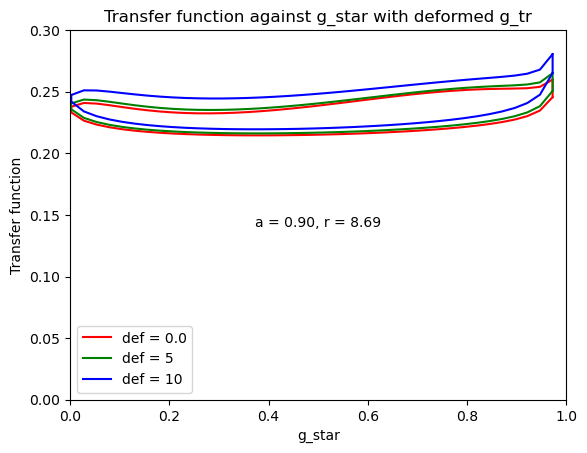

In [36]:
spin = 0.90
inc = np.cos(np.pi/4)
defpars = [0.0, 5, 10]
Mdl = 0.0

r = 8.6948

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']


for defpar in defpars:
    filename = photon_files + r'\photons4trf_a{:.5e}.i{:.2e}.Mdl_{:.2e}.dp_{:.2e}.dat'.format(spin, inc, Mdl, defpar)
    # Add num pad to exopnent
    filename = filename.replace('e+0', 'e+00')
    filename = filename.replace('e-0', 'e-00')
    branch_1_select, branch_2_select = transfer_function(spin, inc, defpar, Mdl, selection=r, selet_tor=0.005, clean=0.30, custom_name=filename)
    
    # Connect first points and last points of the two branches
    
    
    # Plot transfer function against g_star
    # plt.plot(branch_1_select['gstar'], branch_1_select['transfer'], label='Branch 1', color='r')
    # plt.plot(branch_2_select['gstar'], branch_2_select['transfer'], label='Branch 2', color='r')
    plt.plot(branch_1_select['gstar'], branch_1_select['transfer_ori'], label='def = {}'.format(defpar), color=colors[defpars.index(defpar)])
    plt.plot(branch_2_select['gstar'], branch_2_select['transfer_ori'], color=colors[defpars.index(defpar)])
    # Connect first points and last points of the two branches
    plt.plot([branch_1_select['gstar'].iloc[0], branch_2_select['gstar'].iloc[0]], [branch_1_select['transfer_ori'].iloc[0], branch_2_select['transfer_ori'].iloc[0]], color=colors[defpars.index(defpar)])
    plt.plot([branch_1_select['gstar'].iloc[-1], branch_2_select['gstar'].iloc[-1]], [branch_1_select['transfer_ori'].iloc[-1], branch_2_select['transfer_ori'].iloc[-1]], color=colors[defpars.index(defpar)])
    plt.xlabel('g_star')
    plt.ylabel('Transfer function')

    # Set scale
    plt.ylim(0, 0.3)
    plt.xlim(0, 1)

# Label spin and radius
plt.title('Transfer function against g_star with deformed g_tr')
plt.text(0.5, branch_1_select['transfer_ori'].max()*0.5, 'a = {:.2f}, r = {:.2f}'.format(spin, r), ha='center')

plt.legend()
plt.savefig('gtr_{:.2f}.png'.format(spin))
plt.show()

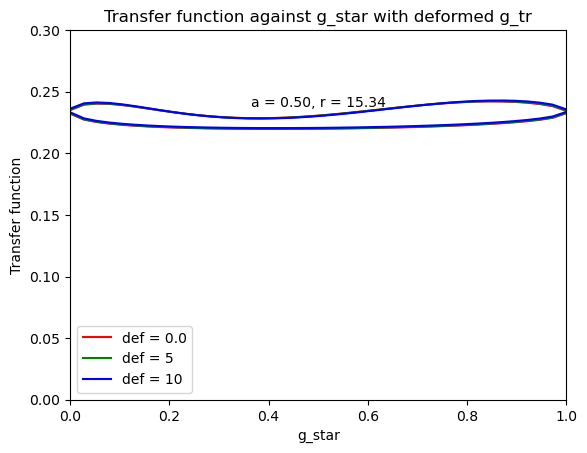

In [20]:
spin = 0.5
inc = np.cos(np.pi/4)
defpars = [0.0, 5, 10]
Mdl = 0.0

# r = 7.317
r = 15.344

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']


for defpar in defpars:
    filename = photon_files + r'\photons4trf_a{:.5e}.i{:.2e}.Mdl_{:.2e}.dp_{:.2e}.dat'.format(spin, inc, Mdl, defpar)
    # Add num pad to exopnent
    filename = filename.replace('e+0', 'e+00')
    filename = filename.replace('e-0', 'e-00')
    branch_1_select, branch_2_select = transfer_function(spin, inc, defpar, Mdl, selection=r, selet_tor=0.005, clean=False, custom_name=filename)

    # Plot transfer function against g_star
    # plt.plot(branch_1_select['gstar'], branch_1_select['transfer'], label='Branch 1', color='r')
    # plt.plot(branch_2_select['gstar'], branch_2_select['transfer'], label='Branch 2', color='r')
    plt.plot(branch_1_select['gstar'], branch_1_select['transfer_ori'], label='def = {}'.format(defpar), color=colors[defpars.index(defpar)])
    plt.plot(branch_2_select['gstar'], branch_2_select['transfer_ori'], color=colors[defpars.index(defpar)])
    plt.xlabel('g_star')
    plt.ylabel('Transfer function')

    # Set scale
    plt.ylim(0, 0.3)
    plt.xlim(0, 1)
    
# Label spin and radius
plt.title('Transfer function against g_star with deformed g_tr')
plt.text(0.5, branch_1_select['transfer_ori'].max()*0.98, 'a = {:.2f}, r = {:.2f}'.format(spin, r), ha='center')
    
plt.legend()
plt.savefig('gtr_{:.2f}.png'.format(spin))
plt.show()